In [3]:
## Description: Estimate effect of management training study on employee engagement score
# Random assignment of managers into or not into management training
# Measure the outcome of engagement of employees from the managers
# Some managers received the training even though not assigned to it - randomization not valid, need observational study design

## Data taken from Causal Inference in Python


In [32]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix
from joblib import Parallel, delayed # for parallel processing
from toolz import partial
from dowhy import CausalModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# treatment is intervention, outcome is engagement_score, rest of vars are covariates
# reduce or even eliminate the bias when estimating the causal relationship between management training and employee engagement
df = pd.read_csv("management_training.csv")
df.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843


In [6]:
df.shape

In [7]:
df.dtypes

departament_id             int64
intervention               int64
engagement_score         float64
tenure                     int64
n_of_reports               int64
gender                     int64
role                       int64
last_engagement_score    float64
department_score         float64
department_size            int64
dtype: object

In [8]:
# df['intervention'] = df['intervention'].astype('str')
df['intervention'] = df['intervention'].astype('bool')

In [9]:
df['engagement_score'].describe()

count    1.039100e+04
mean     3.829313e-17
std      1.000000e+00
min     -3.111431e+00
25%     -7.033152e-01
50%     -3.449486e-02
75%      6.724723e-01
max      3.563639e+00
Name: engagement_score, dtype: float64

#### Naive Estimate of Average Treatment Effect (ATE)

In [10]:
treatment_avg = df.loc[df['intervention'] == 1,'engagement_score'].mean()
control_avg = df.loc[df['intervention'] == 0,'engagement_score'].mean()

print('Treatment Average:', treatment_avg.round(4))
print('Control Average:',  control_avg.round(4))
print('Treatment Effect:', (treatment_avg - control_avg).round(4))

Treatment Average: 0.1999
Control Average: -0.2347
Treatment Effect: 0.4346


### DoWhy: Graphical Causal Model Model based Inference

Represent prior knowledge about the modeling problem with a DAG.

In [11]:
# Graph Modeling Language (GML), define the nodes and edges
# Each edge has a source and target
nodes = ['engagement_score','intervention','tenure','last_engagement_score','department_score','department_size','n_of_reports', 'gender', 'role']
edges = [
    ('tenure', 'engagement_score'),
    ('last_engagement_score', 'engagement_score'),
    ('department_score', 'engagement_score'),
    ('department_size', 'engagement_score'),
    ('n_of_reports', 'engagement_score'),
    ('gender', 'engagement_score'),
    ('role', 'engagement_score'),
    
    ('intervention', 'engagement_score'),

    ('tenure', 'intervention'), # confounders
    ('last_engagement_score', 'intervention'),
    ('department_score', 'intervention'),
    ('department_size', 'intervention'),
    ('n_of_reports', 'intervention'),
    ('gender', 'intervention'),
    ('role', 'intervention'),

    ('n_of_reports', 'tenure'),
    ('tenure', 'role'),
    ('n_of_reports', 'role')

]

# Generate the GML graph
gml_string = 'graph [directed 1\n'
for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'
for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target"{edge[1]}"]\n'
gml_string += ']'

In [25]:
print(gml_string)

graph [directed 1
	node [id "engagement_score" label "engagement_score"]
	node [id "intervention" label "intervention"]
	node [id "tenure" label "tenure"]
	node [id "last_engagement_score" label "last_engagement_score"]
	node [id "department_score" label "department_score"]
	node [id "department_size" label "department_size"]
	node [id "n_of_reports" label "n_of_reports"]
	node [id "gender" label "gender"]
	node [id "role" label "role"]
	edge [source "tenure" target"engagement_score"]
	edge [source "last_engagement_score" target"engagement_score"]
	edge [source "department_score" target"engagement_score"]
	edge [source "department_size" target"engagement_score"]
	edge [source "n_of_reports" target"engagement_score"]
	edge [source "gender" target"engagement_score"]
	edge [source "role" target"engagement_score"]
	edge [source "intervention" target"engagement_score"]
	edge [source "tenure" target"intervention"]
	edge [source "last_engagement_score" target"intervention"]
	edge [source "dep

In [12]:
df['intervention'].unique()

array([ True, False])

In [13]:
# Can add common causes, effect modifiers, instrumental vars
# common causes = covariates, vars with more than 1 effect
model = CausalModel(
    data = df,
    treatment = 'intervention',
    outcome = 'engagement_score',
    graph=gml_string
)

Model to find the causal effect of treatment ['intervention'] on outcome ['engagement_score']


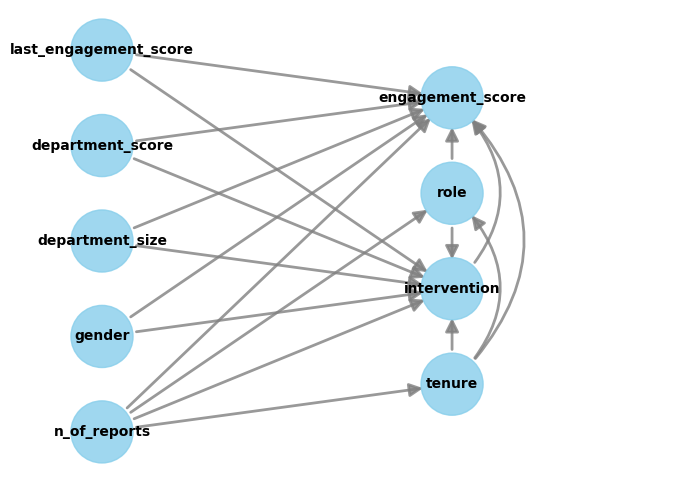

In [14]:
model.interpret()

In [15]:
# There are three types of estimates DoWhy finds: backdoor, frontdoor and instrumental variable (iv)
estimand = model.identify_effect(proceed_when_unidentifiable=True) # proceed_when_unidentifiable ignore any unobserved confounding
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(E[engagement_score|n_of_reports,gender,tenure,role,department_
d[intervention]                                                               

                                             
size,department_score,last_engagement_score])
                                             
Estimand assumption 1, Unconfoundedness: If U→{intervention} and U→engagement_score then P(engagement_score|intervention,n_of_reports,gender,tenure,role,department_size,department_score,last_engagement_score,U) = P(engagement_score|intervention,n_of_reports,gender,tenure,role,department_size,department_score,last_engagement_score)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimation Methods

#### Distance Matching

In [16]:
causal_estimate_dmatch  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

print('Distance Matching ATE:', round(causal_estimate_dmatch.value,4))

Distance Matching ATE: 0.294


In [17]:
print(causal_estimate_dmatch)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(E[engagement_score|n_of_reports,gender,tenure,role,department_
d[intervention]                                                               

                                             
size,department_score,last_engagement_score])
                                             
Estimand assumption 1, Unconfoundedness: If U→{intervention} and U→engagement_score then P(engagement_score|intervention,n_of_reports,gender,tenure,role,department_size,department_score,last_engagement_score,U) = P(engagement_score|intervention,n_of_reports,gender,tenure,role,department_size,department_score,last_engagement_score)

## Realized estimand
b: engagement_score~intervention+n_of_reports+gender+tenure+role+department_size+department_score+last_engagemen

#### Linear Regression

In [18]:
causal_estimate_linreg  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression',
    test_significance=True)

print('Linear Regression ATE:', round(causal_estimate_linreg.value,4))

Linear Regression ATE: 0.272


#### Propensity Score Stratification

In [19]:
causal_estimate_pmatching  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_matching',
    target_units='ate')

print('Propensity Score Matching ATE:', round(causal_estimate_pmatching.value,4))

c:\Users\arsep\anaconda3\envs\ds1\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Propensity Score Matching ATE: 0.2877


#### Propensity Score Matching

In [20]:
causal_estimate_pstrat  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_stratification',
    target_units='ate')

print('Propensity Score Stratification ATE:', round(causal_estimate_pstrat.value,4))

Propensity Score Stratification ATE: 0.3113


#### Propensity Score Weighting

In [21]:
causal_estimate_weighting  = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_weighting',
    target_units='ate',
    method_params={"weighting_scheme":"ips_weight"})

print('Weighting ATE:', round(causal_estimate_weighting.value,4))

Weighting ATE: 0.3133


#### DML

Use DML for a multicomponent estimator (GradientBoostingRegressor with LassoCV from EconML package). </br>
DML fits three ML models to compute de-biased estimates of treatment effects. First, it predicts the outcome from the controls. Then, it predicts the treatment from controls. Last, it fits the model that regresses residuals from the second model on the residuals from the first model.

In [34]:
causal_estimate_dml = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False),
        },
        'fit_params': {}}, # did not specify any initial parameters of the models
        target_units='ate'
)

print('DML ATE:', round(causal_estimate_dml.value,4))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


DML ATE: 0.2426


### Refuting the Estimate: Robustness Tests

Test the estimators against refutation tests (p-value < .05).
Cannot verify that the estimate if correct, but can falisfy if the expected behavior is violated. Increases confidence in the correctness. If a model fails any of the tests then the estimated causal effect is not very robust. Can improve the model by adding relevant confounders or by using a different causal model/method </br></br>
Test Types: </br>
Invariant Transformations = Changes in the data that should not change the estimate (e.g., random common cause, data subset) </br>
Nullifying Transformations = After the data change, the causal estimate is zero. Any estimator whose result varies significantly from zero on the new data fails the test (e.g., placebo treatment).

In [22]:
# Adding a random common cause variable
# adds randomly drawn covariates to data and reruns the analysis to see if the causal estimate changes or not.
# if our assumption was originally correct then the causal estimate shouldn't change much.
# p-value is not < .05, therefore there is statistically significant difference between the estimated effect and new effect
# The new common cause, w variable, does not have a sizable impact on the estimated effect
res_random=model.refute_estimate(estimand,causal_estimate_pmatching,method_name="random_common_cause",random_seed=1)
print(res_random)

Refute: Add a random common cause
Estimated effect:0.2877413959999619
New effect:0.28774139599996185
p value:1.0



In [23]:
# Replacing treatment with a random placebo variable for the treatment and reruns the analysis
# New estimated effect should go to 0
# p-value is above .05 and therefore we cannot reject the null hypothesis that the estimated effect is greater than 0
# fails the test
res_placebo=model.refute_estimate(estimand,causal_estimate_pmatching,method_name="placebo_treatment_refuter",placebo_type="permute",num_simulations=20,random_seed=1)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:0.2877413959999619
New effect:-0.00769065852035104
p value:0.34682167756609117



In [24]:
# Creates a random subset of the data and checks whether the casual estimates vary across subsets.
# there should not be much variation
# similar to cross-validation
# p-value is not < .05 and therefore the estimated effect and new effect are not different
res_subset=model.refute_estimate(estimand,causal_estimate_pmatching,method_name="data_subset_refuter",subset_fraction=.9,random_seed=1)
print(res_subset)

Refute: Use a subset of data
Estimated effect:0.2877413959999619
New effect:0.2897363065583994
p value:0.8400000000000001



### Sensitivity Tests

Adding an unobserved common cause variable (adding a confounder that is associated with both treatment and outcome)
</br>A sensitivity test to check the sensitivity towards a violation of the backdoor assumption: that all common causes are observed.

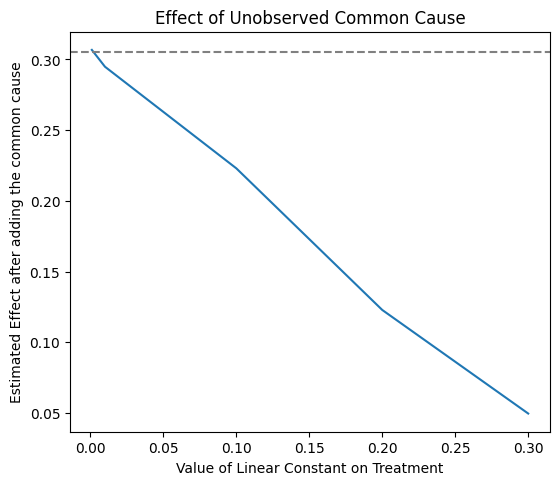

Refute: Add an Unobserved Common Cause
Estimated effect:0.30551158447764065
New effect:(0.049630519702854974, 0.3067834067622372)



In [80]:
# Use manual selection of effect strength parameters
# The estimate decreases as the hypothesized confounding on treatment increases
res_unobserved_auto = model.refute_estimate(estimand, causal_estimate_pmatching, method_name="add_unobserved_common_cause",
                                           confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                           effect_strength_on_treatment=np.array([0.001, 0.01, 0.1, 0.2, 0.3]), effect_strength_on_outcome=0.03)
print(res_unobserved_auto)

c:\Users\arsep\anaconda3\envs\ds1\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


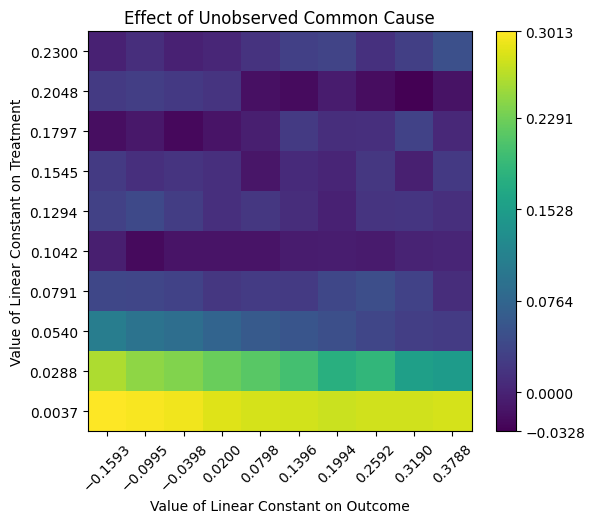

Refute: Add an Unobserved Common Cause
Estimated effect:0.30551158447764065
New effect:(-0.03281540344766409, 0.30130572631889674)



In [73]:
# Use automatic selection of effect strength parameters
res_unobserved_auto = model.refute_estimate(estimand, causal_estimate_pmatching, method_name="add_unobserved_common_cause",
                                           confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear")
print(res_unobserved_auto)